In [1]:
import argparse
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import pearsonr, spearmanr
from scipy.interpolate import interp1d
import sys
import time
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
import tqdm

In [2]:
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath("__file__"))))
from dist_ir.ir import Topology
from dist_ir.executor import infer_types, Simulator
from dist_ir.executor.cost_model import CostModel
from dist_ir.transforms import filter_transform, mlp_dhp_transform
from dist_ir.mlp import mlp

In [3]:
DEVICE_THROUGHPUT = 1.38e13 #6.7e12 # FLOPS
DRAM_BANDWIDTH = 7e11 # ???
PCIE_BANDWIDTH = 77 # Gbps

In [4]:
class Mlp(torch.nn.Module):
    def __init__(self, num_hidden_layers, hidden_dim):
        super().__init__()
        self.blocks = [
            torch.nn.Linear(hidden_dim, hidden_dim, bias=False)
            for _ in range(num_hidden_layers)
        ]
        for i, block in enumerate(self.blocks):
            for j, param in enumerate(block.parameters()):
                if j > 0:
                    raise ValueError(f"Block {i} has more than 1 parameter!")
                self.register_parameter(f"w{chr(ord('A')+i)}", param)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
            relu = torch.nn.ReLU()
            x = relu(x)
        return x

In [5]:
def setup(
    local_rank, world_size, backend="nccl", master_addr="localhost", master_port="12355"
):
    os.environ["MASTER_ADDR"] = master_addr
    os.environ["MASTER_PORT"] = master_port
    torch.distributed.init_process_group(
        backend, world_size=world_size, rank=local_rank
    )

In [6]:
def cleanup():
    torch.distributed.destroy_process_group()

In [7]:
def run(config):
    (
        local_rank,
        world_size,
        num_hidden_layers,
        batch_size,
        hidden_dim,
        num_warmup_steps,
        num_profiling_steps,
    ) = config
    model = Mlp(num_hidden_layers, hidden_dim).to(local_rank)
    loss_fn = torch.nn.MSELoss().to(local_rank)
    x = torch.randn(size=(batch_size // world_size, hidden_dim)).to(local_rank)
    labels = torch.randn(size=(batch_size // world_size, hidden_dim)).to(local_rank)
    if world_size > 1:
        setup(local_rank, world_size)
        model = DDP(model, device_ids=[local_rank], output_device=local_rank)
    runtimes = []
    torch.cuda.synchronize()
    for i in range(num_warmup_steps + num_profiling_steps):
        start = time.time()
        y = model(x)
        loss_fn(y, labels).backward()
        if world_size > 1:
            torch.distributed.barrier()
        duration = time.time() - start
        runtimes.append(duration)
    if world_size > 1:
        cleanup()
    return np.median(runtimes[num_warmup_steps:])

In [8]:
def distributed_driver(num_hidden_layers, batch_size, hidden_dim, world_size):
    configs = [
        (rank, world_size, num_hidden_layers, batch_size, hidden_dim, 10, 100)
        for rank in range(world_size)
    ]
    with torch.multiprocessing.Pool(world_size) as p:
        results = p.map(run, configs)
    print(
        f"world_size={world_size}, "
        f"num_hidden_layers={num_hidden_layers}, "
        f"batch_size={batch_size}, "
        f"hidden_dim={hidden_dim}, "
        f"runtime={np.mean(results)}"
    )
    return np.mean(results)

In [9]:
def simulate(num_hidden_layers, batch_size, hidden_dim, world_size):
    topology = Topology()
    d0 = topology.add_device(
        "gpu", throughput=DEVICE_THROUGHPUT, dram_bandwidth=DRAM_BANDWIDTH
    )
    for i in range(world_size):
        di = topology.add_device(
            "gpu", throughput=DEVICE_THROUGHPUT, dram_bandwidth=DRAM_BANDWIDTH
        )
        topology.set_bandwidth(d0, di, float("inf"))
        for j in range(1, i + 1):
            dj = topology.devices[j]
            topology.set_bandwidth(di, dj, PCIE_BANDWIDTH)
    function = mlp(
        batch_size, hidden_dim, hidden_dim, hidden_dim, num_hidden_layers, d0
    )
    function = infer_types(function, function.inputs)
    if world_size > 1:
        dp_function = mlp_dhp_transform(function, world_size, 1, 1, topology.devices, 1)
        dp_function = infer_types(dp_function, dp_function.inputs)
        # dp_function = filter_transform(dp_function)
    else:
        dp_function = function
    simulator = Simulator(CostModel(topology))
    simulation = simulator.interpret(
        dp_function,
        (v.type for v in dp_function.inputs),
    )
    return max([simulation.timestamps[d] for d in simulation.timestamps])

In [10]:
def parse_csv(filename):
    results = []
    with open(filename, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            results.append(
                (
                    row["world_size"],
                    row["num_hidden_layers"],
                    row["batch_size"],
                    row["hidden_dim"],
                    row["runtime"],
                )
            )
    return results

In [11]:
def sweep(
    all_world_sizes, all_num_hidden_layers, all_batch_sizes, all_hidden_dims, filename, func
):
    fieldnames = ["world_size", "num_hidden_layers", "batch_size", "hidden_dim", "runtime"]
    with open(filename, "w") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for world_size in all_world_sizes:
            for num_hidden_layers in all_num_hidden_layers:
                for batch_size in all_batch_sizes:
                    for hidden_dim in all_hidden_dims:
                        runtime = func(
                            num_hidden_layers, batch_size, hidden_dim, world_size
                        )
                        writer.writerow(
                            {
                                "world_size": world_size,
                                "num_hidden_layers": num_hidden_layers,
                                "batch_size": batch_size,
                                "hidden_dim": hidden_dim,
                                "runtime": runtime,
                            }
                        )

In [12]:
all_world_sizes = [1, 2, 4]
all_num_hidden_layers = [8, 16, 32]
all_batch_sizes = [2048, 4096, 8192]
all_hidden_dims = [512, 1024, 2048]
# sweep(
#     all_world_sizes,
#     all_num_hidden_layers,
#     all_batch_sizes,
#     all_hidden_dims,
#     "data_parallel_runtimes.csv",
#     distributed_driver,
# )
sweep(
    all_world_sizes,
    all_num_hidden_layers,
    all_batch_sizes,
    all_hidden_dims,
    "data_parallel_simulated_runtimes.csv",
    simulate,
)

In [13]:
real_results = parse_csv("data_parallel_runtimes.csv")
simulated_results = parse_csv("data_parallel_simulated_runtimes.csv")

In [14]:
real_throughputs = defaultdict(list)
simulated_throughputs = defaultdict(list)
print(f"world_size,# layers,batch size,hidden dim,model size (MB),real,simulated,ratio")
for real, simulated in zip(real_results, simulated_results):
    world_size = int(real[0])
    num_hidden_layers = int(real[1])
    batch_size = int(real[2])
    hidden_dim = int(real[3])
    real_runtime = float(real[4])
    simulated_runtime = float(simulated[4])
    model_size = hidden_dim * hidden_dim * num_hidden_layers * 4 / (1024 * 1024)
    print(
        f"{world_size},{num_hidden_layers},{batch_size},{hidden_dim},"
        f"{model_size},{real_runtime*1000:.2f},"
        f"{simulated_runtime*1000:.2f},"
        f"{(simulated_runtime/real_runtime):.2f}x"
    )
    real_throughputs[world_size].append(batch_size / real_runtime / 1000)
    simulated_throughputs[world_size].append(batch_size / simulated_runtime / 1000)

world_size,# layers,batch size,hidden dim,model size (MB),real,simulated,ratio
1,8,2048,512,8.0,4.09,1.98,0.48x
1,8,2048,1024,32.0,9.26,7.72,0.83x
1,8,2048,2048,128.0,33.37,30.48,0.91x
1,8,4096,512,8.0,5.31,3.95,0.74x
1,8,4096,1024,32.0,17.80,15.39,0.86x
1,8,4096,2048,128.0,68.97,60.76,0.88x
1,8,8192,512,8.0,9.54,7.89,0.83x
1,8,8192,1024,32.0,34.15,30.74,0.90x
1,8,8192,2048,128.0,127.62,121.33,0.95x
1,16,2048,512,16.0,7.14,3.96,0.55x
1,16,2048,1024,64.0,18.69,15.44,0.83x
1,16,2048,2048,256.0,67.90,60.95,0.90x
1,16,4096,512,16.0,10.72,7.90,0.74x
1,16,4096,1024,64.0,36.18,30.78,0.85x
1,16,4096,2048,256.0,140.70,121.51,0.86x
1,16,8192,512,16.0,19.20,15.77,0.82x
1,16,8192,1024,64.0,69.24,61.47,0.89x
1,16,8192,2048,256.0,259.61,242.64,0.93x
1,32,2048,512,32.0,13.19,7.92,0.60x
1,32,2048,1024,128.0,37.56,30.88,0.82x
1,32,2048,2048,512.0,136.91,121.89,0.89x
1,32,4096,512,32.0,21.49,15.79,0.74x
1,32,4096,1024,128.0,72.85,61.56,0.85x
1,32,4096,2048,512.0,283.97,243.02,0.86x
1,32,8192,512,32.0,38

Pearson's correlation: 0.9272318124145403 (p=1.9287517995842477e-35)
Spearman's correlation: 0.9332881662149954 (p=7.009308160675867e-37)


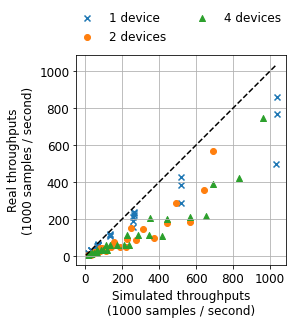

In [15]:
plt.rcParams["font.size"] = 12
all_simulated_throughputs = []
all_real_throughputs = []
for world_size in simulated_throughputs:
    all_real_throughputs += real_throughputs[world_size]
for world_size in simulated_throughputs:
    all_simulated_throughputs += simulated_throughputs[world_size]
all_simulated_throughputs = np.array(all_simulated_throughputs)
all_real_throughputs = np.array(all_real_throughputs)
r, p = pearsonr(all_simulated_throughputs, all_real_throughputs)
print(f"Pearson's correlation: {r} (p={p})")
r, p = spearmanr(all_simulated_throughputs, all_real_throughputs)
print(f"Spearman's correlation: {r} (p={p})")
# m, b = np.polyfit(simulated_throughputs, real_throughputs, 1)
x_new = np.linspace(min(all_simulated_throughputs.min(), all_real_throughputs.min()),
                    max(all_simulated_throughputs.max(), all_real_throughputs.max()),
                    500)
plt.plot(x_new, x_new, color="black", linestyle="--")
# f = interp1d(simulated_throughputs, m * simulated_throughputs + b, kind="linear")
# y_smooth = f(x_new)
# plt.plot(x_new, y_smooth, label="Best fit")
#plt.plot(x_new, x_new)
colors = ["b", "orange", "g", "purple"]
markers = ['x', 'o', '^'] 
# scaled_model_sizes = np.array(model_sizes, dtype=np.float32)
# scaled_model_sizes -= np.min(model_sizes)
# scaled_model_sizes *= 1.0 / (np.max(model_sizes) - np.min(model_sizes))
# scaled_model_sizes *= 224
# scaled_model_sizes += 32
labels = ["1 device", "2 devices", "4 devices"]
lines = []
for i, world_size in enumerate(simulated_throughputs):
    lines.append(plt.scatter(
        simulated_throughputs[world_size],
        real_throughputs[world_size],
#         s=scaled_model_sizes,
#         facecolors="none",
#         edgecolors="b",
        marker=markers[i],
        label=labels[i]
    ))
plt.grid()
plt.xticks([0, 200, 400, 600, 800, 1000])
plt.yticks([0, 200, 400, 600, 800, 1000])
plt.xlabel("Simulated throughputs\n(1000 samples / second)")
plt.ylabel("Real throughputs\n(1000 samples / second)")
plt.gca().set_aspect('equal', adjustable='box')
leg = plt.figlegend(lines, labels, loc="upper center", ncol=2)
leg.get_frame().set_linewidth(0.0)
# Get the bounding box of the original legend.
bb = leg.get_bbox_to_anchor().transformed(plt.gca().transAxes.inverted())

# Change to location of the legend.
yOffset = 0.1
bb.y0 += yOffset
bb.y1 += yOffset
leg.set_bbox_to_anchor(bb, transform=plt.gca().transAxes)
plt.tight_layout()
plt.savefig("data_parallel_simulation_performance.pdf", dpi=600, bbox_inches="tight")